# SOURCE CODE FOR TASK A and B

#### Import Libraries

In [2]:
# Libraries to import and merge csv files
import os
import glob
import chardet

# Libraries for Network Analysis
import math
import folium
import spaghetti
import osmnx as ox
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

from esda import moran
from sklearn.cluster import KMeans
from shapely.geometry import Point, LineString

# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

-------------

#### Get the geographical area of Leeds from OpenStreetMap as a GeoDataFrame

In [3]:
# Picking "Leeds" city and "drive roads" using OpenStreetMap(osmnx library as ox)
PLACE_OF_INTEREST = "Leeds, United Kingdom"
leeds_graph = ox.graph_from_place(PLACE_OF_INTEREST, network_type="drive")

# Get the geographical area of Leeds from ox map as a GeoDataFrame with a buffer of 10m
leeds_area = ox.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=10)

----------------

### 1. Merge all the CSV files

In [4]:
ACCIDENTS_DIR = "./data/" 

# We will only use the Easting(Long) and Northing(Latitude) columns in the data
USE_COLS = ["Grid Ref: Easting", "Grid Ref: Northing"]

# Create an empty list to store the individual dataframes
dfs = []

# Loop through all CSV files in the directory and append the dataframes to the list
for path, subdir, _ in os.walk(ACCIDENTS_DIR):
    for csv_file in glob.glob(os.path.join(path, "*.csv")):
        # Detect the encoding of the file
        with open(csv_file, 'rb') as f:
            result = chardet.detect(f.read())
            encoding = result['encoding']
        # Read the file into a pandas dataframe with the detected encoding
        df = pd.read_csv(csv_file, usecols=USE_COLS, encoding=encoding)
        dfs.append(df)

# Concatenate all dataframes in the list into a single dataframe
accidents_df = pd.concat(dfs, axis=0, ignore_index=True)
        
print("Found {} CSV files in {}".format(len(dfs), ACCIDENTS_DIR))
print("Total no. of crimes loaded: {}".format(len(accidents_df)))

Found 7 CSV files in ./data/
Total no. of crimes loaded: 16284


### 2. Data preparation

In [5]:
# Rename the columns
accidents = accidents_df.rename(columns={"Grid Ref: Easting": "Easting", "Grid Ref: Northing": "Northing"})

# Some accidents do not record a location, so drop any that have 'NaN' for the longitude or latitude
accidents = accidents.dropna(subset=['Easting', 'Northing'])
print("Total no. of located crimes filtered: {}".format(len(accidents)))

geometry = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(accidents['Easting'], accidents['Northing'])])
geometry.set_crs(epsg=27700, inplace=True)
geometry.head()


Total no. of located crimes filtered: 16284


,geometry
0,POINT (436147.000 434957.000)
1,POINT (436147.000 434957.000)
2,POINT (436147.000 434957.000)
3,POINT (436147.000 434957.000)
4,POINT (436147.000 434957.000)


----------------

### The Accidents in Leeds between 2013-2019

<Figure size 1200x1400 with 0 Axes>

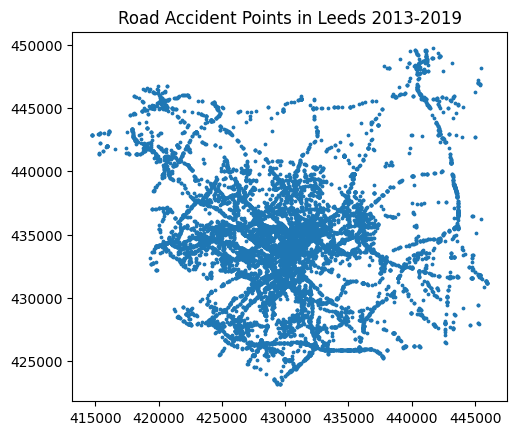

In [6]:
plt.figure(figsize=(12,14))
geometry.plot(markersize=3)
plt.title('Road Accident Points in Leeds 2013-2019')
plt.show()

#### Filter it to a 1km2 area within Leeds City 

In [23]:
# the coordinates of all the traffic accidnets in Leeds
X = accidents[['Easting', 'Northing']].to_numpy()

# Kmeans clustering
km = KMeans(n_clusters=10, random_state=0).fit(X)

# clustering centers
centers = gpd.GeoDataFrame(geometry=[Point(xy) for xy in km.cluster_centers_])  

# draw a square buffer of 1 km2 to each clustering center
buffer = centers.buffer(500, cap_style=3)   
buffer.set_crs(epsg=27700, inplace=True)

# count the accident points within each buffer
count = buffer.apply(lambda x: np.sum(geometry.within(x)))   
buffer = buffer.to_crs(epsg=4326)

# select the buffer with the most accident points
polygon = buffer[count.idxmax()] 

graph = ox.graph_from_polygon(polygon, network_type='drive') 

print(f'The selected area has {max(count)} traffic accident points.')

The selected area has 418 traffic accident points.


### Visualise the Clusterings (n=10)

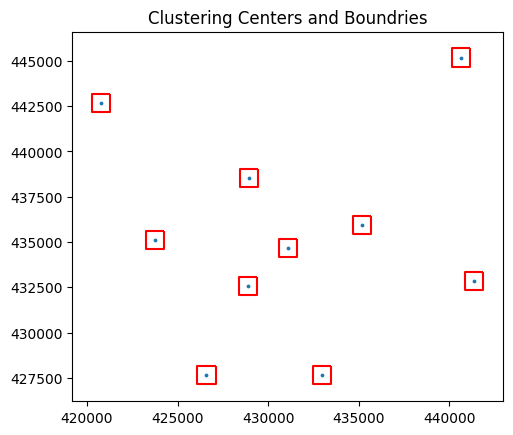

In [24]:
# Visualising the Clustering(n=10) centers and their boundaries
fig, ax = plt.subplots()
buffer = buffer.to_crs(epsg=27700)
buffer.boundary.plot(ax=ax, color='red')
centers.plot(ax=ax, markersize=3)
ax.set_title('Clustering Centers and Boundries')
plt.savefig('clustering.png', dpi=200)
plt.show()

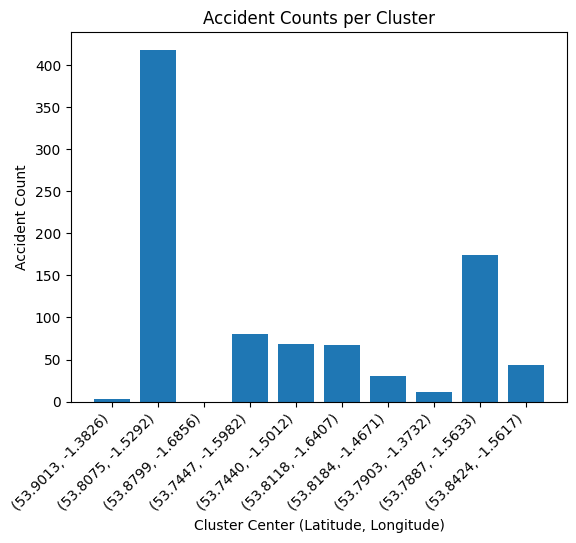

In [25]:
# Convert buffer to the same CRS as centers
buffer = buffer.to_crs(epsg=27700)

# Calculate the centroids of the buffers
centroids = buffer.centroid.to_crs(epsg=4326)

# Combine cluster index, accident count, and cluster center coordinates
cluster_data = list(zip(range(len(count)), count, centroids))

# Sort cluster_data by accident count
cluster_data.sort(key=lambda x: x[1], reverse=True)

# Separate the data into separate lists
indices, accident_counts, cluster_centers = zip(*cluster_data)

# Plot the histogram
fig, ax = plt.subplots()
ax.bar(indices, accident_counts)

# Set x-axis labels to cluster center coordinates
labels = [f"({c.y:.4f}, {c.x:.4f})" for c in cluster_centers]
ax.set_xticks(indices)
ax.set_xticklabels(labels, rotation=45, ha="right")

# Set axis labels and title
ax.set_xlabel("Cluster Center (Latitude, Longitude)")
ax.set_ylabel("Accident Count")
ax.set_title("Accident Counts per Cluster")
plt.savefig('accident_counts_histogram.png', dpi=200)
plt.show()

--------------

Southwest corner: (53.8029913, -1.5368245)
Northeast corner: (53.8119468, -1.5218382)


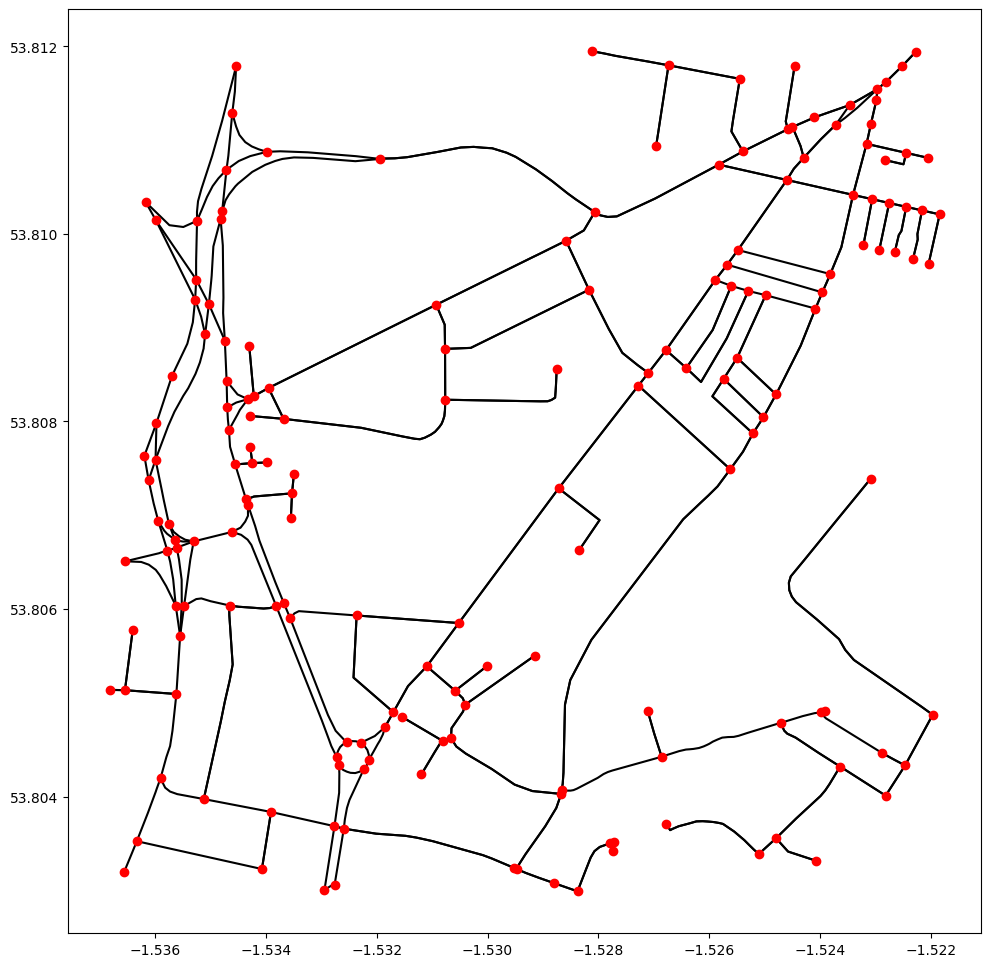

In [26]:
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

# Get the minimum and maximum latitude and longitude values of the graph.
min_lat, min_lon = nodes['y'].min(), nodes['x'].min()
max_lat, max_lon = nodes['y'].max(), nodes['x'].max()

# The Southwest corner (min_lat, min_lon) and Northeast corner (max_lat, max_lon)
sw_corner = (min_lat, min_lon)
ne_corner = (max_lat, max_lon)

print(f'Southwest corner: {sw_corner}')
print(f'Northeast corner: {ne_corner}')

base_network = edges.plot(color="k", zorder=0, figsize =(12, 12))
nodes.plot(ax=base_network, color="r", zorder=2)
plt.show()

#### Haversine Distance

In [27]:
# Find the area using Haversine Distance
def haversine(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371e3  # Earth radius in meters

    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * \
        math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

# calculate the lengths of the bounding box sides
side_ns = haversine(sw_corner, (ne_corner[0], sw_corner[1]))  # North-South side
side_we = haversine(sw_corner, (sw_corner[0], ne_corner[1]))  # West-East side

# calculate the area
area = side_ns * side_we
area_km2 = area/1000000

print(f"The area of the bounding box is approximately \
{round(area)} square meters ({round(area_km2)} square kilometers).")

The area of the bounding box is approximately 979988 square meters (1 square kilometers).


### Basic Stats

In [28]:
stats_dict = ox.basic_stats(graph)

In [29]:
stats_dict

{'n': 173,
 'm': 353,
 'k_avg': 4.08092485549133,
 'edge_length_total': 24267.670000000027,
 'edge_length_avg': 68.74694050991509,
 'streets_per_node_avg': 2.7976878612716765,
 'streets_per_node_counts': {0: 0, 1: 29, 2: 1, 3: 120, 4: 22, 5: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1676300578034682,
  2: 0.005780346820809248,
  3: 0.6936416184971098,
  4: 0.12716763005780346,
  5: 0.005780346820809248},
 'intersection_count': 144,
 'street_length_total': 15178.411000000006,
 'street_segment_count': 225,
 'street_length_avg': 67.45960444444447,
 'circuity_avg': 1.029142478903887,
 'self_loop_proportion': 0.0}

In [30]:
node_density = stats_dict['n'] / area
intersection_density = stats_dict['intersection_count'] / area
edge_density = stats_dict['m'] / area
is_planar, counterexample = nx.check_planarity(graph, counterexample=True)

In [31]:
# Calculate the Spatial Diameter
def spatial_diameter(G):
    diameter = 0
    for u in G.nodes():
        # Find the shortest path from u to all other nodes
        dist = nx.shortest_path_length(G, source=u, weight='length')
        # Find the most distant node from u
        v = max(dist, key=dist.get)
        # Find the shortest path from u to v
        path = nx.shortest_path(G, source=u, target=v, weight='length')
        # Calculate the weighted length of the path
        path_length = sum(dict(G[s][e])[0]['length'] \
                          for s, e in zip(path[:-1], path[1:]))
        # Update the diameter if the new path is longer
        diameter = max(diameter, path_length)
    return diameter

print(spatial_diameter(graph), "meters")

2339.712 meters


In [17]:
print(f"Number of edges: {stats_dict['m']}")
print(f"Number of nodes: {stats_dict['n']}")  
print(f"Node Density: {node_density}")
print(f"Edge Density: {edge_density}")
print(f"Intersection Density: {intersection_density}")
print(f"Averge node degree: {stats_dict['k_avg']}")
print(f"Average edge length: {stats_dict['edge_length_avg']}")
print(f"Average circuity: {stats_dict['circuity_avg']}")
print(f"Total edge length: {stats_dict['edge_length_total']}")
print(f"Average street length: {stats_dict['street_length_avg']}")
print(f"Total street length: {stats_dict['street_length_total']}")

Number of edges: 353
Number of nodes: 173
Node Density: 0.00017653274293359856
Edge Density: 0.00036020842922289187
Intersection Density: 0.00014694054903143465
Averge node degree: 4.08092485549133
Average edge length: 68.74694050991509
Average circuity: 1.029142478903887
Total edge length: 24267.670000000027
Average street length: 67.45960444444447
Total street length: 15178.411000000006


#### Planarity

In [18]:
is_planar, counterexample = nx.check_planarity(graph, counterexample=True)
print(is_planar)

True


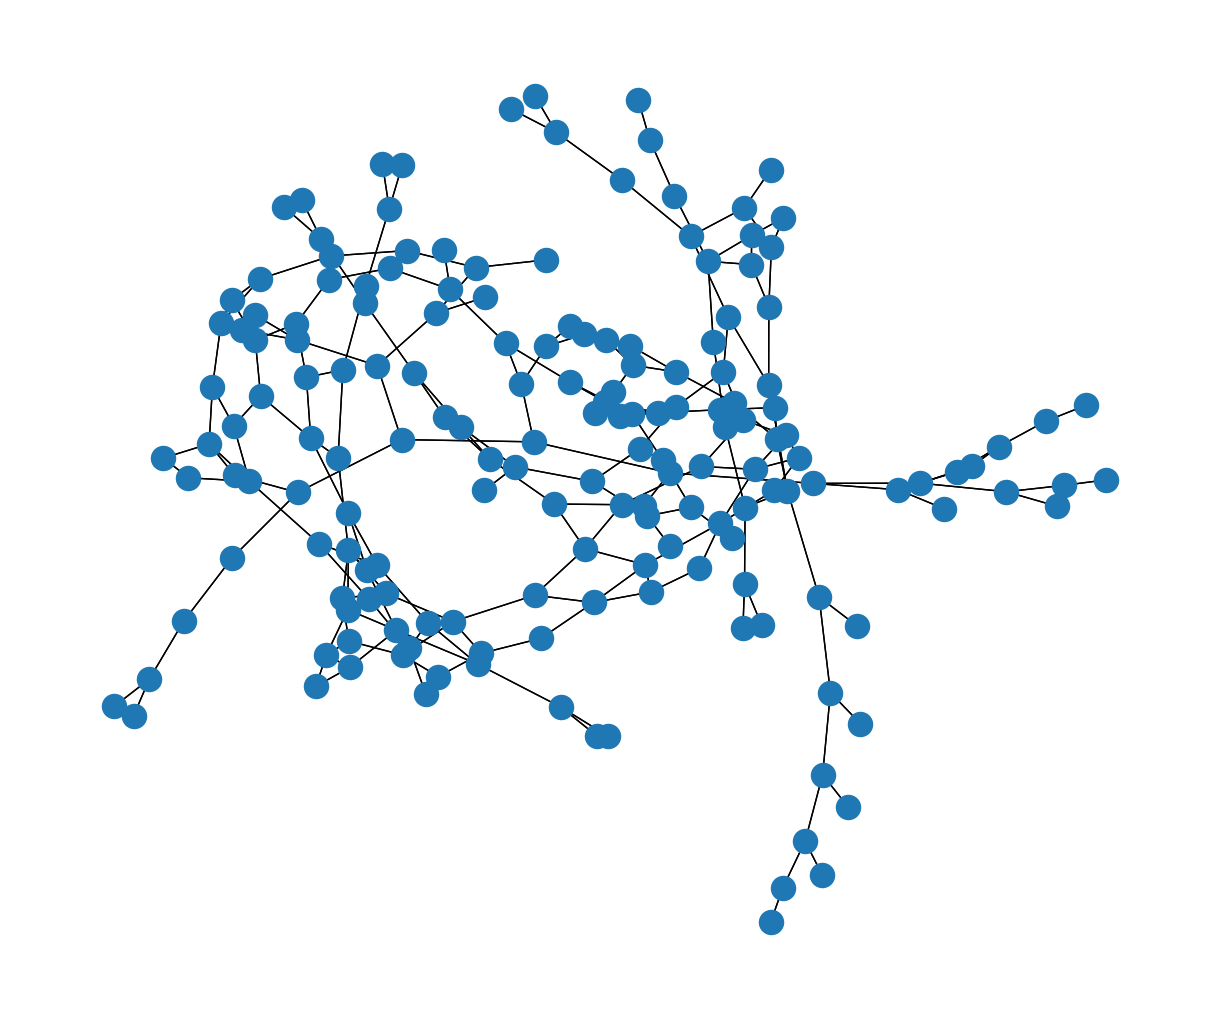

In [19]:
plt.figure(figsize=(12, 10))
nx.draw(counterexample)
plt.show()

In [22]:
# Some edges are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = nx.get_node_attributes(graph, 'x')
y_values = nx.get_node_attributes(graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

In [23]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_gdf = gpd.GeoDataFrame(pd.DataFrame(road_lines), crs='epsg:4326')
roads_gdf  = roads_gdf.to_crs(epsg=27700)
roads_gdf.head()

,osmid,name,highway,maxspeed,oneway,reversed,length,geometry,lanes,ref,bridge,junction,access
0,23120678,Skinner Lane,tertiary,30 mph,False,True,11.470,"LINESTRING (430880.497 434252.389, 430869.360 ...",NaN,NaN,NaN,NaN,NaN
1,38422455,Regent Street,trunk,NaN,True,False,67.194,"LINESTRING (430880.497 434252.389, 430870.014 ...",2,A61,NaN,NaN,NaN
2,"[169591262, 440408598, 169591263]",Skinner Lane,tertiary,30 mph,False,False,208.128,"LINESTRING (430880.497 434252.389, 430885.224 ...",2,NaN,yes,NaN,NaN
3,"[23161080, 616100090]",NaN,trunk,30 mph,True,False,84.637,"LINESTRING (430652.496 434972.340, 430681.807 ...",2,A61,NaN,NaN,NaN
4,23161081,NaN,trunk_link,30 mph,True,False,104.571,"LINESTRING (430652.496 434972.340, 430688.037 ...",2,NaN,NaN,NaN,NaN


<Figure size 640x480 with 0 Axes>

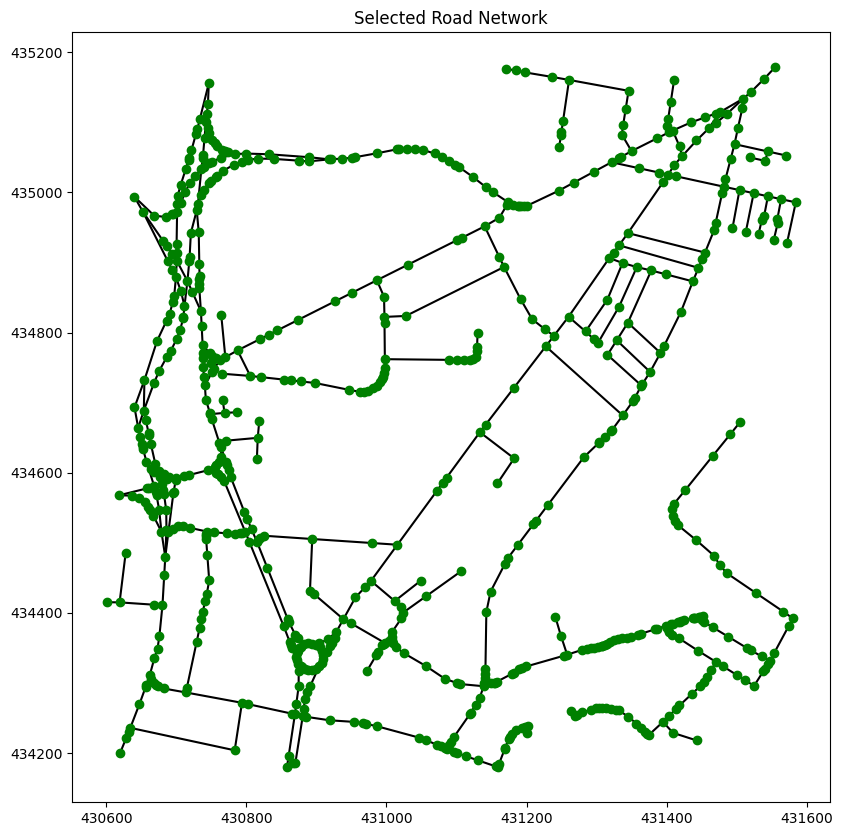

In [24]:
point_graph = spaghetti.Network(in_data=roads_gdf)
point_graph.extractgraph()
nodes_df, edges_df = spaghetti.element_as_gdf(point_graph, vertices=True, arcs=True)
plt.figure()
base_network = edges_df.plot(color='k', zorder=0, figsize=(10, 10))
nodes_df.plot(ax=base_network, color='g', zorder=2)
plt.title('Selected Road Network')
plt.savefig('selectednetwork.png', dpi=200)
plt.show()

<Figure size 640x480 with 0 Axes>

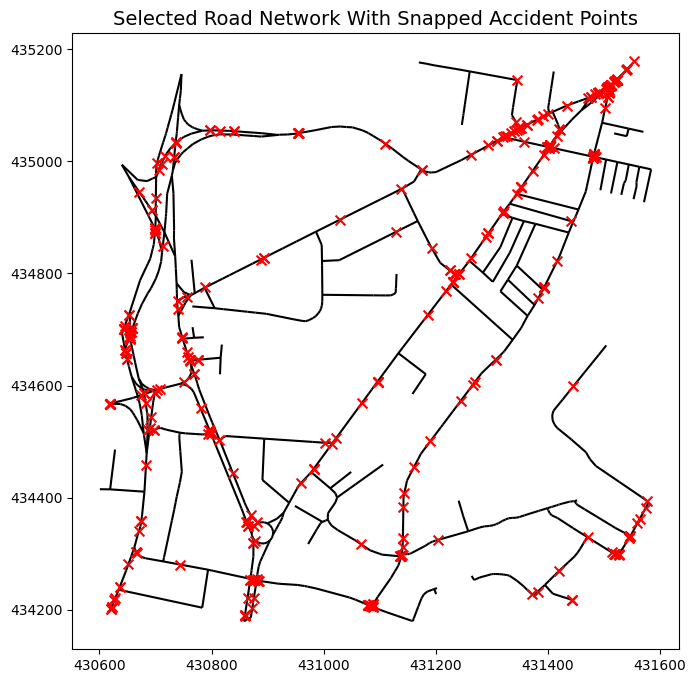

In [25]:
# change crs to 4326 and filter accident points that fall within the selected area
zone_point = geometry.to_crs(epsg=4326)
zone_point = zone_point.loc[zone_point.within(polygon)]

# change crs to 27700 and snap accident points to arcs
zone_point = zone_point.to_crs(epsg=27700)
point_graph.snapobservations(zone_point, 'accidents')

# plotting
plt.figure()
base_network = edges_df.plot(color='k', zorder=0, figsize=(10, 8))
snapped_accidents = spaghetti.element_as_gdf(point_graph, pp_name='accidents', snapped=True)
snapped_accidents.plot(color='r', marker='x', markersize=50, zorder=1, ax=base_network)
plt.title('Selected Road Network With Snapped Accident Points', fontsize=14)
plt.savefig('snapped.png', dpi=200)
plt.show()

<Figure size 640x480 with 0 Axes>

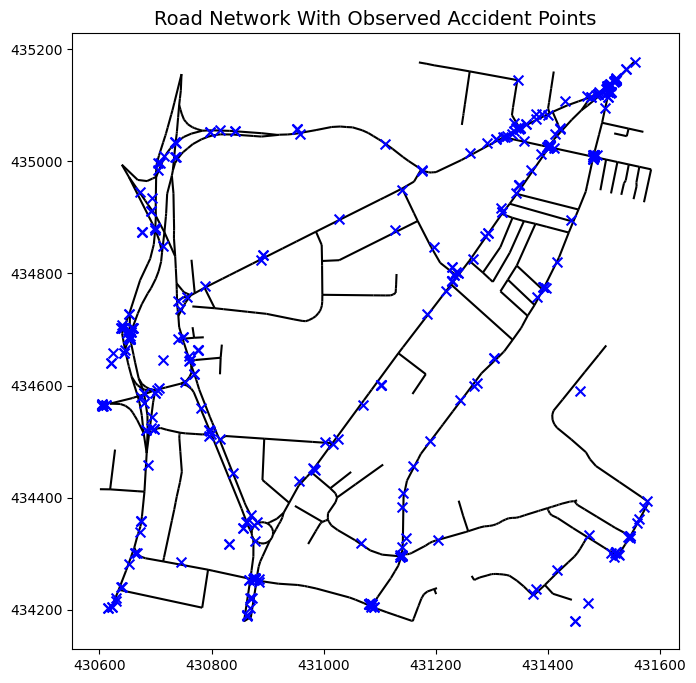

In [26]:
plt.figure()
base_network = edges_df.plot(color="k", zorder=0, figsize =(10, 8))
observed_accidents = spaghetti.element_as_gdf(point_graph, pp_name='accidents', snapped=False)
# zone_point.plot(color="b", marker="x", markersize=50, zorder=1, ax=base_network)
observed_accidents.plot(color="b", marker="x", markersize=50, zorder=1, ax=base_network)
plt.title('Road Network With Observed Accident Points', fontsize=14)
plt.savefig('observed.png', dpi=200)
plt.show()

In [27]:
kres = point_graph.GlobalAutoK(point_graph.pointpatterns['accidents'], nsteps=100)
print(kres.lam)

0.027493386687761787


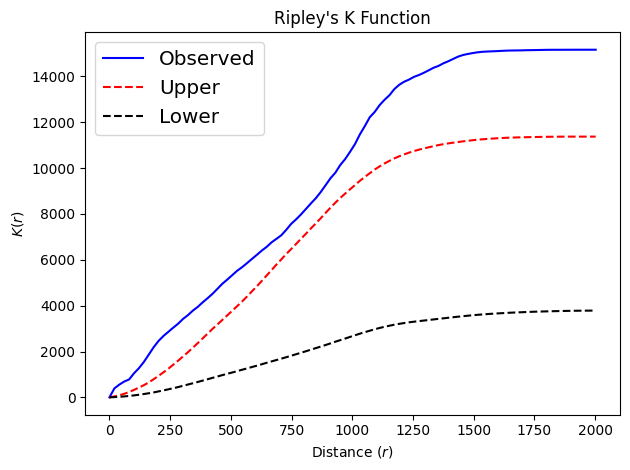

In [28]:
fig, ax = plt.subplots(dpi=100)

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")
ax.set_title('Ripley\'s K Function')
fig.tight_layout()
plt.savefig('kfunc.png', dpi=200)

In [29]:
# point pattern of road accidens
pointpat = point_graph.pointpatterns['accidents']   

# count the number of accident points in each arc
count_by_edge = point_graph.count_per_link(pointpat.obs_to_arc, graph=False)

# weight of the arcs in the network
weights = point_graph.w_network    

edges = weights.neighbors.keys()
values = [count_by_edge[edge] if edge in count_by_edge.keys() else 0 for _, edge in enumerate(edges)]

# calculate global moran's I
mor = moran.Moran(values, weights)     

print(f'Global Moran\'s I: {mor.I}')
print(f'P value: {mor.p_sim}')
print(f'Expected Moran\'s I under null hypothesis: {mor.EI}')
print(f'Z score: {mor.z_sim}')

Global Moran's I: 0.35084249421617136
P value: 0.001
Expected Moran's I under null hypothesis: -0.0013404825737265416
Z score: 10.683525439322759


In [30]:
edges = point_graph.edges # road edges
points = snapped_accidents.geometry.to_numpy() # accident points
min_dist = np.full(len(points), np.inf) # store the min distance of each accident point
frac = np.zeros(len(points)) # store the fraction of length

# for each accident point, calculate the distance to all the edge point
# find the min dist as the dist to the nearest intersection
for i in range(len(points)):
    x = points[i].x
    y = points[i].y
    for edg in edges:
        dist = list(point_graph.compute_distance_to_vertices(x, y, edg))
        if min(dist) < min_dist[i]:
            min_dist[i] = min(dist)
            frac[i] = min(dist)/sum(dist)   # calculate fraction

print(f'mean distance to the nearest intersection: {np.mean(min_dist)}')
print(f'median distance to the nearest intersection: {np.median(min_dist)}')
print(f'mean fraction of the road length: {np.mean(frac)}')

mean distance to the nearest intersection: 17.02534013947458
median distance to the nearest intersection: 7.05169002253292
mean fraction of the road length: 0.16681704931454638


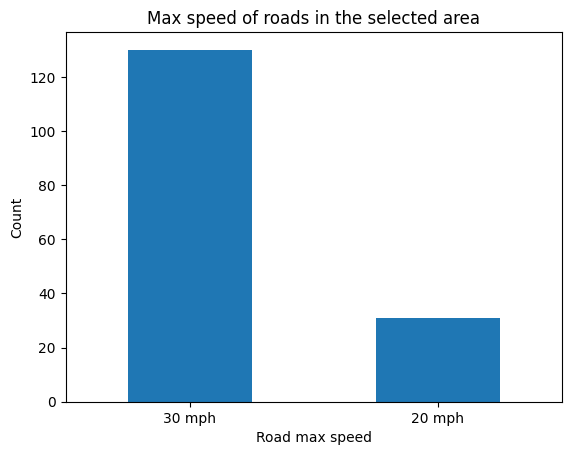

In [31]:
plt.figure()
roads_gdf['maxspeed'].value_counts().plot(kind='bar', ylabel='Count', xlabel='Road max speed')
plt.xticks(rotation=0)
plt.title('Max speed of roads in the selected area')
plt.savefig('maxspeed.png', dpi=200)
plt.show()

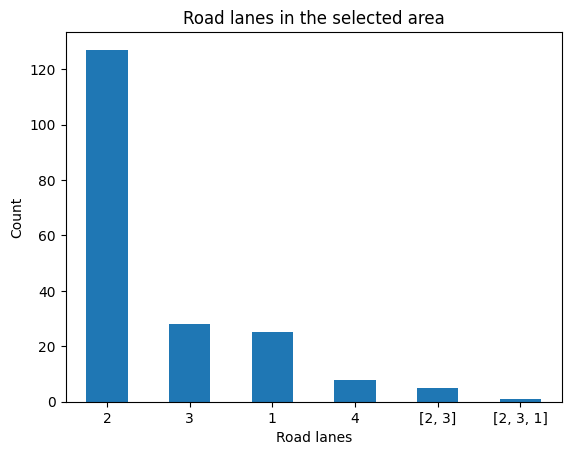

In [32]:
plt.figure()
roads_gdf['lanes'].value_counts().plot(kind='bar', ylabel='Count', xlabel='Road lanes')
plt.xticks(rotation=0)
plt.title('Road lanes in the selected area')
plt.savefig('roadlanes.png', dpi=200)
plt.show()

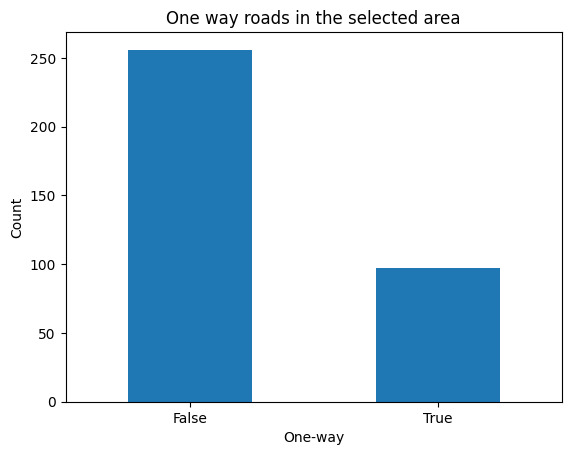

In [33]:
plt.figure()
roads_gdf['oneway'].value_counts().plot(kind='bar', ylabel='Count', xlabel='One-way')
plt.xticks(rotation=0)
plt.title('One way roads in the selected area')
plt.show()